This is the second simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using curved tracks, 8 detector layers.

Training on wider parameter range and more realistic sigma. Compare minimization results from neural net with analytic values.

To account for wider range, train on 1 million events (10x previous)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

### Tracker toy model

Muon decaying at (x=0,z), producing positron with momentum (px,pz). 8 layers at given z (infinite in x) that will return x position (Gaussian). $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = |p|\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$p_z = |p|\cos(\frac{qB}{\gamma m} t + \phi)$

$\tan \phi = \frac{v_x(0)}{v_z(0)} = \frac{p_x(0)}{p_z(0)}$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [106]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45
N_det = 8
det_zs = np.linspace(0,(N_det-1)*0.12,N_det) #z-layers

def calc_x(z,p,phi):
    # p is in GeV -> *1e9/c
    p *= 1e9/c
    
    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
    sq = np.sqrt(sq)

    return (p*np.cos(phi) - sq)/B

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event z_toy,p_toy,phi_toy
#toy = [-0.12,2.4,0.25]
toy=[-0.34,1.9,0.06]
z_toy, p_toy, phi_toy = toy

#for Gaussian
sigma = 3e-4

[0.01968015 0.05590199 0.10726634 0.17619791 0.26686027 0.38709087
 0.55492327 0.84282955]


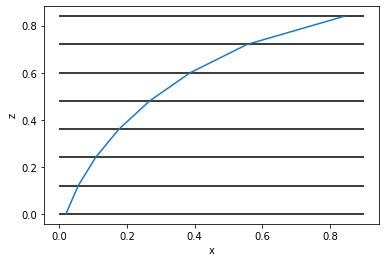

In [5]:
test = calc_x(det_zs+0.1,0.5,0.15)
print(test)
plt.plot(test,det_zs)
plt.hlines(det_zs,0,0.9,color='black')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [6]:
def generate_event(z, p, phi):
    # generates an event from given z, p, phi
    # returns length 8 array of measured x-positions
    
    xs = np.empty(N_det)
    dist = det_zs-z
    x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        if np.isnan(x_exp[i]): pass #need to handle this later, set to -1?
        xs[i] = x_hit(x_exp[i],sigma).rvs()
    return xs

#toy MC
def MC_events(N_events, zlims=(-0.5, -0.0001), plims=(1.5,3), phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi (isn't really uniform)
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    
    z = np.random.uniform(*zlims, N_events)
    p = np.random.uniform(*plims, N_events)
    phi = np.random.uniform(*phi_lims, N_events)

    truth = np.vstack([z, p, phi]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(z[i], p[i], phi[i]))

    return events, truth

In [7]:
def plot_event(x_meas,z,p,phi):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title('hit locations')
    ax.set_xlabel('x')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    x_exp = calc_x(det_zs-z,p,phi)
    for i, z_det in enumerate(det_zs):
        #expectation
        x_dist = x_hit(x_exp[i],sigma)
        mu = x_dist.mean()
        std = x_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, x_dist.pdf(times),label=f'z={100*det_zs[i]:.0f} cm')
        
        #measured
        ax.bar(x_meas[i], 50, width=0.003, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

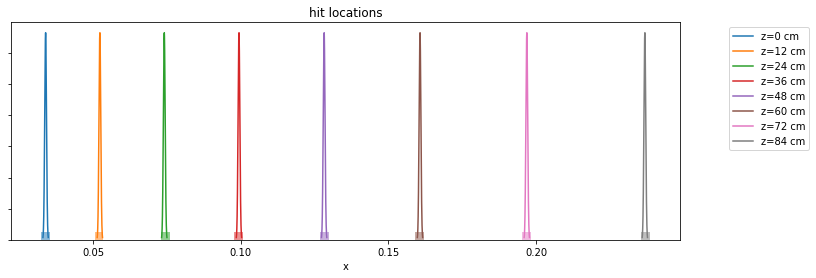

In [107]:
ev = generate_event(*toy)
plot_event(ev,*toy)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [9]:
#log-likelihoods

def hit_pdf(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)
    
    llh = 0
   
    for i,hit in enumerate(x_meas):
        llh -= (hit-xs[i])**2/(2*sigma**2) + np.log(sigma)
    
    #store negative LLH, multiply by -1
    return -llh

In [11]:
grid_spacing = 100

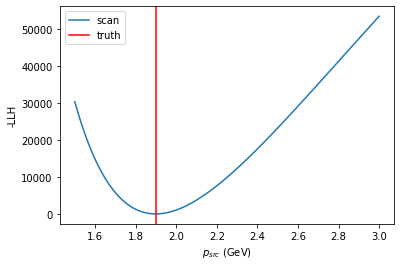

In [76]:
#full range
ps = np.linspace(1.5,3,grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

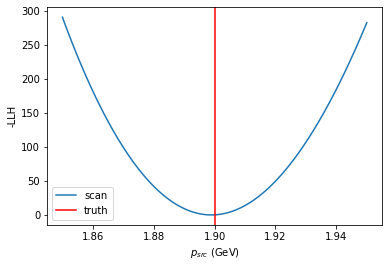

In [77]:
#zoomed in to smaller llhs
ps = np.linspace(p_toy-0.05,p_toy+0.05,grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

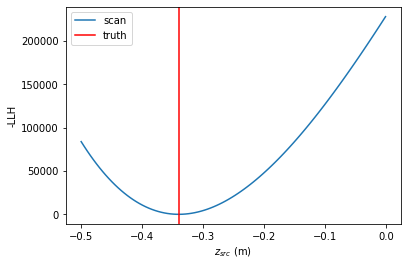

In [78]:
#full range
zs = np.linspace(-0.5,-0.001,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

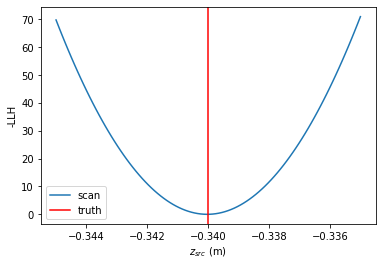

In [79]:
#zoomed in
zs = np.linspace(z_toy-0.005,z_toy+0.005,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

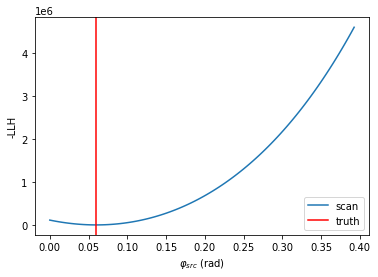

In [80]:
#full range
phis = np.linspace(0, np.pi/8, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

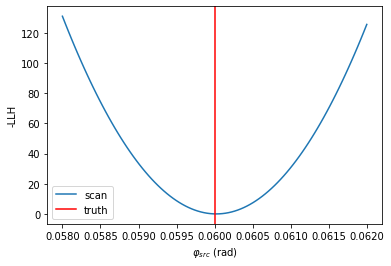

In [81]:
#zoomed in
phis = np.linspace(phi_toy-0.002, phi_toy+0.002, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

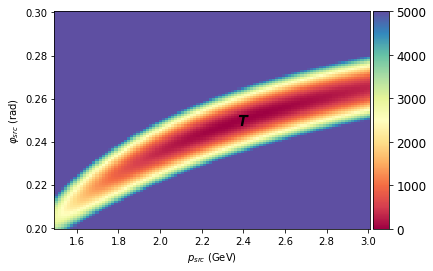

In [28]:
#larger range
ps = np.linspace(1.5,3,grid_spacing)
phis = np.linspace(max(phi_toy-0.05,0), phi_toy+0.05, grid_spacing)

llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), toy)

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=5000)

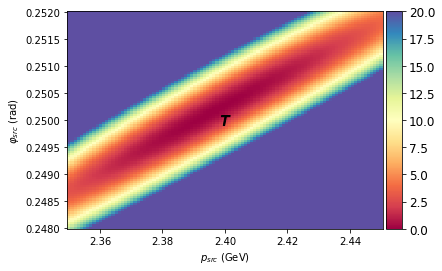

In [29]:
#zoomed in
ps = np.linspace(p_toy-0.05,p_toy+0.05,grid_spacing)
phis = np.linspace(phi_toy-0.002,phi_toy+0.002, grid_spacing)

llh_p_phi_scan = map_2d(hit_pdf, ev, (1, 2), (ps, phis), toy)

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],vmax=20)

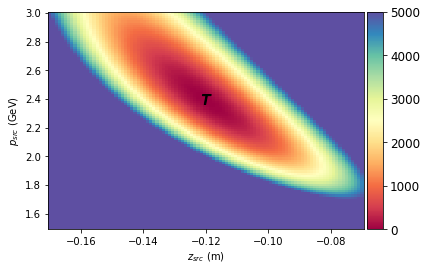

In [34]:
#larger range
ps = np.linspace(1.5,3,grid_spacing)
zs = np.linspace(z_toy-0.05,min(z_toy+0.05,0),grid_spacing)
#zs = np.linspace(1.5*z_toy,-0.001,grid_spacing)

llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=5000)

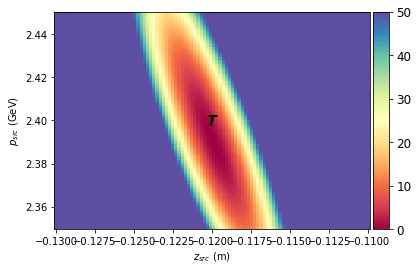

In [31]:
#zoomed in
ps = np.linspace(p_toy-0.05,p_toy+0.05,grid_spacing)
zs = np.linspace(z_toy-0.01,z_toy+0.01,grid_spacing)

llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],vmax=50)

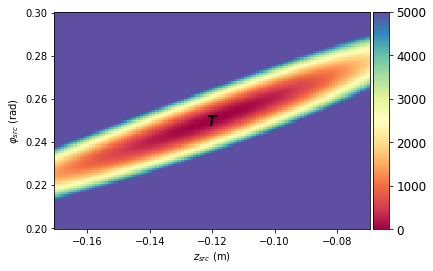

In [33]:
#larger range
zs = np.linspace(z_toy-0.05,min(z_toy+0.05,0),grid_spacing)
#zs = np.linspace(1.5*z_toy,-0.001,grid_spacing)
phis = np.linspace(max(phi_toy-0.05,0), phi_toy+0.05, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), toy)

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=5000)

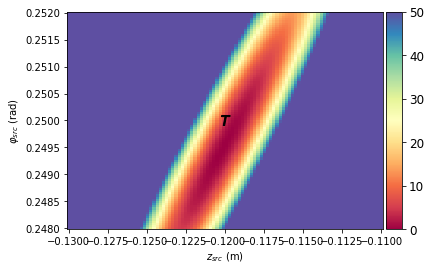

In [20]:
#zoomed in
zs = np.linspace(z_toy-0.01,z_toy+0.01,grid_spacing)
phis = np.linspace(phi_toy-0.002,phi_toy+0.002, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), toy)

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=50)

In [35]:
#make toy MC data for neural net training
N_mc = int(1e6) #previously 1e5
mc, truth = MC_events(N_mc)

In [36]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#separate the hits into single events, add the detector z position
hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

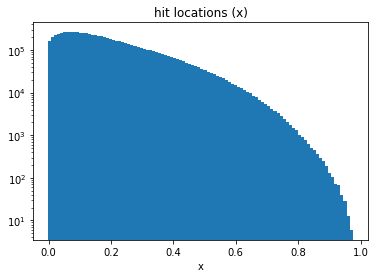

In [37]:
#histogram of hit positions (x)
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [38]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        #d = hits[:,1]-theta[:,0]
        #px = theta[:,1]*tf.math.sin(theta[:,2])
        #pz = theta[:,1]*tf.math.cos(theta[:,2])
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #d,
                 #px,
                 #pz,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
        return out
    
hitnet.trafo = trafo

In [39]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [40]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 5)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         trafo[0][0]                  

In [41]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [42]:
#training

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
3125/3125 [==============================] - 198s 63ms/step - loss: 0.2719 - val_loss: 0.0745
Epoch 2/5
3125/3125 [==============================] - 194s 62ms/step - loss: 0.1235 - val_loss: 0.0818
Epoch 3/5
3125/3125 [==============================] - 195s 62ms/step - loss: 0.1204 - val_loss: 0.0715
Epoch 4/5
3125/3125 [==============================] - 192s 61ms/step - loss: 0.1089 - val_loss: 0.0607
Epoch 5/5
3125/3125 [==============================] - 215s 69ms/step - loss: 0.0967 - val_loss: 0.0488


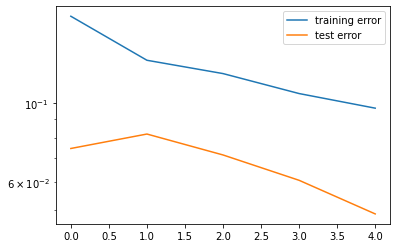

In [43]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear #result is log r(x,theta)
hitnet.llh.compile()

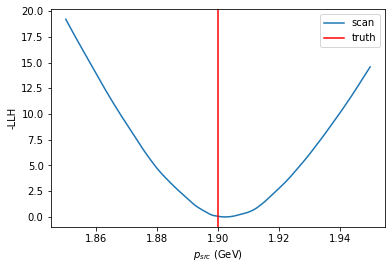

In [82]:
#neural net scan
ps = np.linspace(p_toy-0.05,p_toy+0.05,100)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,ps,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

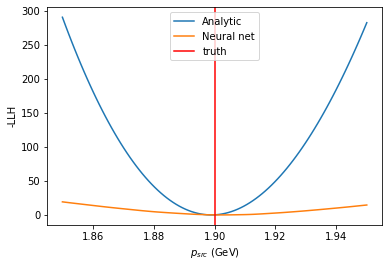

In [83]:
#comparison NN and analytical
llh_p_scan = map_1d(hit_pdf, ev, 1, ps, toy)

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

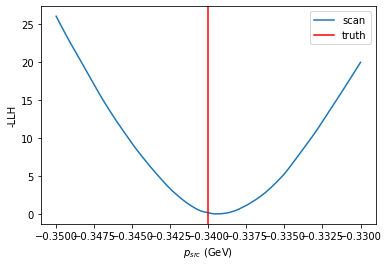

In [84]:
#neural net scan
zs = np.linspace(z_toy-0.01,z_toy+0.01,100)

scan_t = np.vstack([zs,np.ones(grid_spacing)*p_toy,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$p_{src}$ (GeV)')

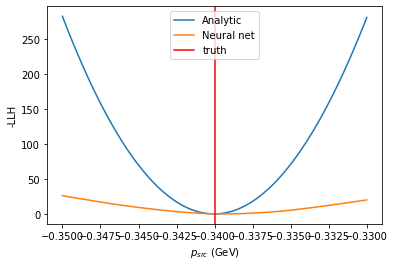

In [85]:
#comparison NN and analytical
llh_z_scan = map_1d(hit_pdf, ev, 0, zs, toy)

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$p_{src}$ (GeV)')

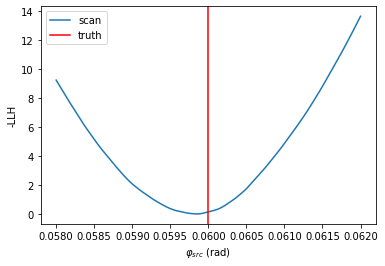

In [86]:
#neural net scan
phis = np.linspace(phi_toy-0.002, phi_toy+0.002, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

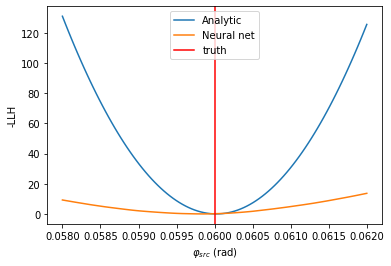

In [87]:
#comparison NN and analytical
llh_phi_scan = map_1d(hit_pdf, ev, 2, phis, toy)

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

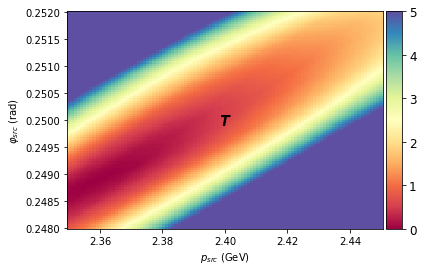

In [50]:
#neural net scan
mg = np.meshgrid(ps,phis)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*z_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_p_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_p_phi_scan, ps, phis, p_toy, phi_toy, 
            axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'], vmax=5)

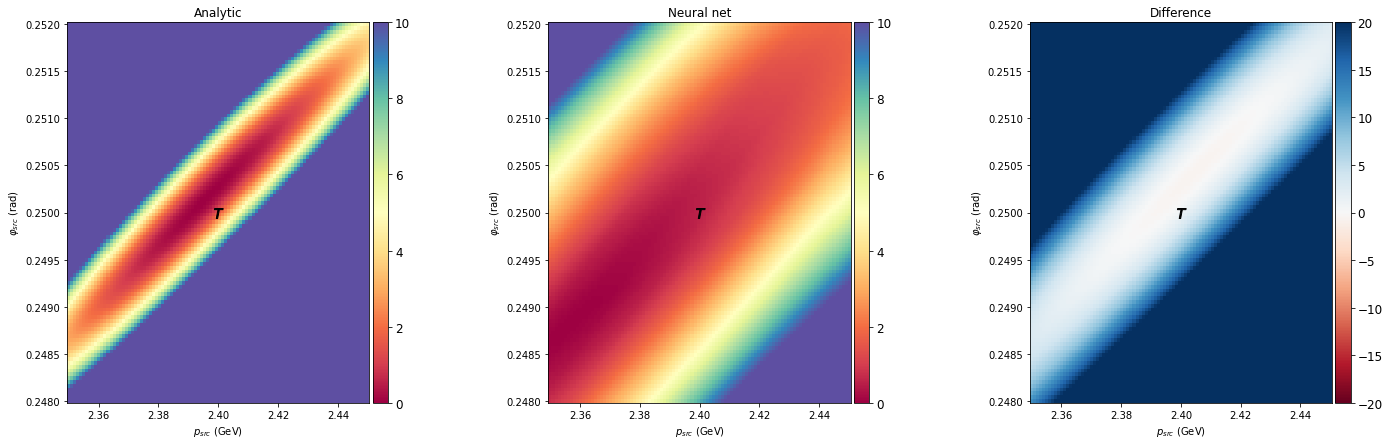

In [51]:
#comparison
llh_p_phi_scan = map_2d(hit_pdf, ev, (1,2), (ps,phis), toy)

plot_2d_diff(llh_p_phi_scan, NN_p_phi_scan, ps, phis, p_toy, phi_toy,
             axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'], vmax=10, vmax_d=20)

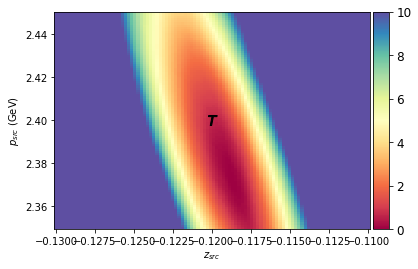

In [52]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*phi_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'], vmax=10)

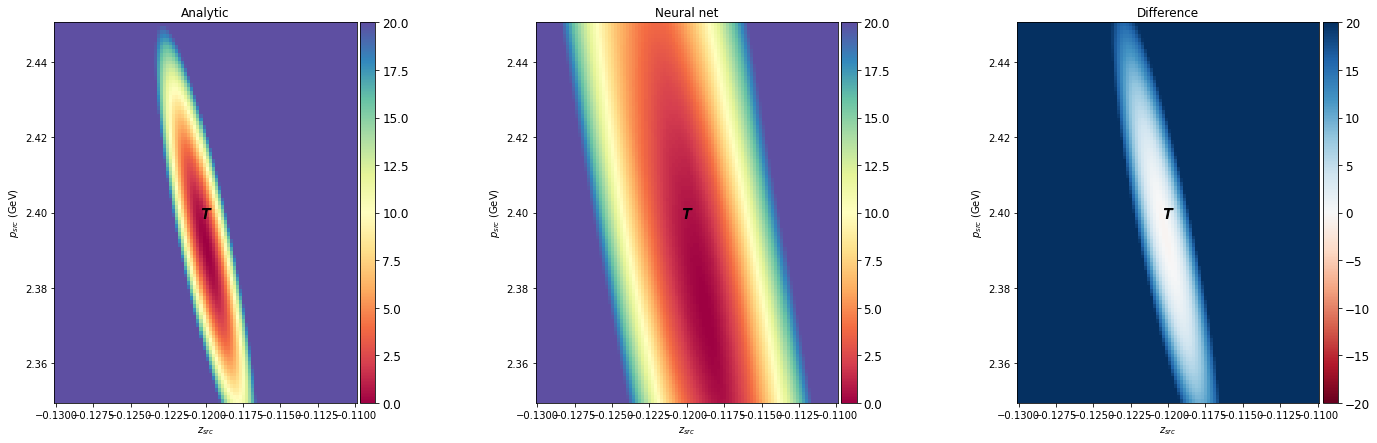

In [53]:
#comparison
llh_z_p_scan = map_2d(hit_pdf, ev, (0, 1), (zs,ps), toy)

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'], vmax=20, vmax_d=20)

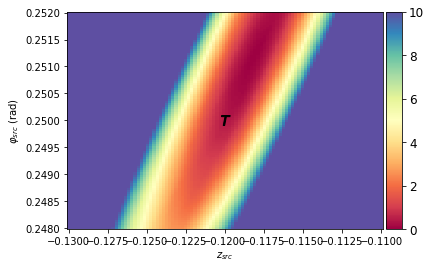

In [54]:
#neural net scan
mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*p_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'], vmax=10)

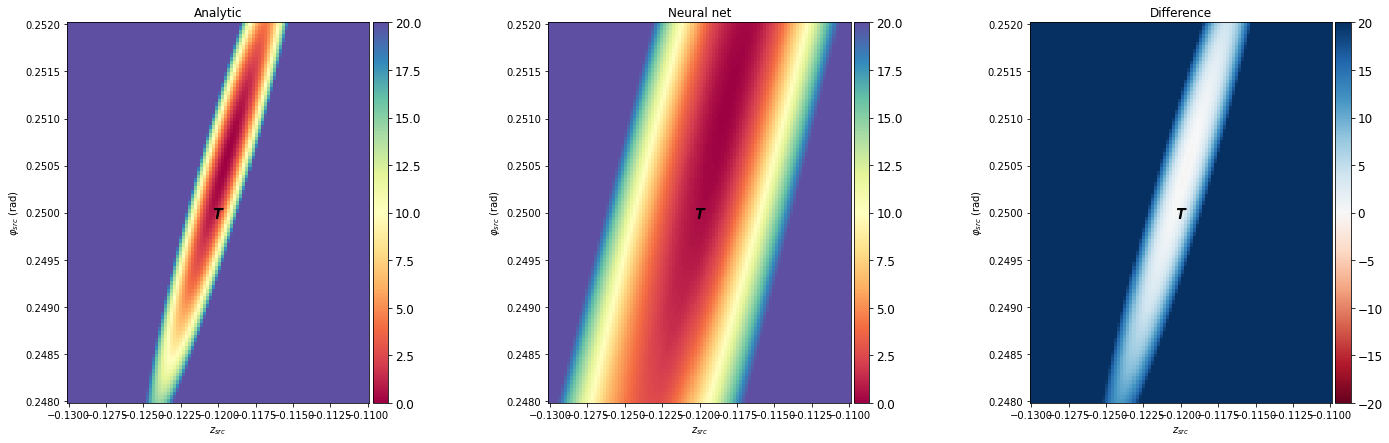

In [56]:
#comparison
llh_z_phi_scan = map_2d(hit_pdf, ev, (0, 2), (zs,phis), toy)

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'], vmax=20, vmax_d=20)

Training with 1e5 samples was a little fickle - sometimes need to run for a few more epochs to get a reasonable result; much more consistent with 1e6 samples

In [108]:
#minimize analytic likelihood
def ana_llh(theta,event):
    #wrapper funtion
    return hit_pdf(event,*theta)

print(*toy)
true_llh_ana = ana_llh(toy,ev)
print(true_llh_ana)

-0.34 1.9 0.06
-62.78673175048174


In [109]:
#minimize nn output
def nn_llh(theta, event):
    #wrapper function
    
    #reshape events into 8x2 array 
    event = np.vstack((event,det_zs)).T

    #repeat truth for each hit in event
    theta = np.array(theta)
    theta = np.repeat(theta[np.newaxis,:], N_det, axis=0)

    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,theta])
    return -1*pred.sum()

print(z_toy,p_toy,phi_toy)
true_llh_nn = nn_llh([z_toy,p_toy,phi_toy],ev)
print(true_llh_nn)

-0.34 1.9 0.06
-37.871337890625


In [94]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("z (mm):",1000*(opt_params.x[0]-z_toy))
        print("p (MeV):",1000*(opt_params.x[1]-p_toy))
        print("phi (rad):",(opt_params.x[2]-phi_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [z_toy,p_toy,phi_toy])/[z_toy,p_toy,phi_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [110]:
#minimize analytic llh with different starting guesses
_, opt_ana = bound_min(ana_llh,[-0.5,2.0,0],[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)
_, opt_ana = bound_min(ana_llh,[-0.001,2.0,np.pi/8],[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)
#try truth as starting guess, see where we land (assume that's global min)
f_ana, opt_ana = bound_min(ana_llh,toy,[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)

starting guess: [-0.5, 2.0, 0]
function value: -47.120877542949145

errors:
z (mm): -158.09869386880732
p (MeV): -120.77474366863039
phi (rad): -0.051039891336875726

relative error (%):
[ 46.49961584  -6.35656546 -85.06648556]


starting guess: [-0.001, 2.0, 0.39269908169872414]
function value: -62.89012480273261

errors:
z (mm): 2.335539014741317
p (MeV): 1.674799139785632
phi (rad): 0.0008303671749432251

relative error (%):
[-0.68692324  0.08814732  1.38394529]


starting guess: [-0.34, 1.9, 0.06]
function value: -62.84701369086009

errors:
z (mm): -0.11393266499143406
p (MeV): -0.3575663739123769
phi (rad): -9.812589030940011e-06

relative error (%):
[ 0.03350961 -0.01881928 -0.01635432]




For first toy event ([-0.12,2.4,0.25]), all minimizations land at roughly the same spot, so looks like there aren't any (deep) local minima to fall into for the analytic likelihood.

For second toy event ([-0.34,1.9,0.06]), the first minimization ends up in a local minimum, so expect NN to also have a harder time depending on starting guess

In [111]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(nn_llh,[-0.5,2.0,0],[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.5, 2.0, 0]
function value: -35.106666564941406

errors:
z (mm): -158.53660747814058
p (MeV): -159.00070327507532
phi (rad): -0.05472481740954695

relative error (%):
[ 46.62841396  -8.36845807 -91.20802902]




In [112]:
f_nn, opt_nn = bound_min(nn_llh,[-0.001,2.0,np.pi/8],[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.001, 2.0, 0.39269908169872414]
function value: 9.367105484008789

errors:
z (mm): 301.3089918389786
p (MeV): 1099.9989636128537
phi (rad): 0.14125046285313267

relative error (%):
[-88.62029172  57.8946823  235.41743809]




In [113]:
f_nn, opt_nn = bound_min(nn_llh,toy,[(-0.5,-0.001),(1.5,3),(0,np.pi/8)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth (NN/ana):",true_llh_nn, true_llh_ana)
    print("NN llh of found min:",f_nn)
    print("Analytic llh of found min (NN/ana):",ana_llh(opt_nn,ev),f_ana)

starting guess: [-0.34, 1.9, 0.06]
function value: -38.219329833984375

errors:
z (mm): 0.9118391985479812
p (MeV): -0.20573736658358044
phi (rad): -6.370430639501823e-06

relative error (%):
[-0.268188   -0.01082828 -0.01061738]


LLH of truth (NN/ana): -37.871337890625 -62.78673175048174
NN llh of found min: -38.219329833984375
Analytic llh of found min (NN/ana): -59.88358423395188 -62.84701369086009


NN output agrees very well with analytic likelihood for both toy example events if we start from the truth parameters. Other guesses get stuck in local minima, so performance will depend strongly on performance of minimizer and initial guess.